## (1) Import

In [16]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## (2) generator

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=64,im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4, kernel_size=3, stride=1),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=3, stride=2),
            self.gen_block(hidden_dim*2, hidden_dim, kernel_size=2, stride=2),
            self.gen_block(hidden_dim, im_chan, kernel_size=2, stride=2, final_layer=True),
        )
    def gen_block(self, in_channel, out_channel, kernel_size=4, stride=2, padding=0, final_layer=False):
      if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
      else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Tanh(),
        )
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.gen(self.unsqueeze_noise(noise))
        return x

## (3) critic

In [18]:
class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.crit_block(im_chan, hidden_dim),
            self.crit_block(hidden_dim, hidden_dim*2),
            self.crit_block(hidden_dim*2, im_chan, final_layer=True),
        )
    def crit_block(self, input, out, kernel_size=4, stride=2, final_layer=False):
      if not final_layer:
          return nn.Sequential(
              nn.Conv2d(input, out, kernel_size, stride),
              nn.BatchNorm2d(out),
              nn.LeakyReLU(0.2, inplace=True)
          )
      else:
          return nn.Sequential(
              nn.Conv2d(input, out, kernel_size, stride)
          )
    
    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## (4) 기타

### (4-1) noise function

In [19]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### (4-2) parameter setup

In [20]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0001
device = 'cuda'

### (4-3) data loading

In [21]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size = batch_size,
    shuffle = True)

## (5) loss function

### (5-1) optimizer

In [22]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr)

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### (5-2) gradient penalty

In [23]:
def get_gradient(crit, real, fake, epsilon):
  mixed_images = real*epsilon + fake*(1-epsilon)
  mixed_scores = crit(mixed_images)

  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True,
  )[0]
  return gradient

In [24]:
def gradient_penalty(gradient):
  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm -1)**2)
  return penalty

### (5-3) loss function

In [25]:
def get_crit_loss (crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda*gp
    
    return crit_loss

In [26]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

## (6) image display


In [27]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## (7) training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 1: Generator loss: -0.7885213576257234, Critic loss: 0.03257578374911102


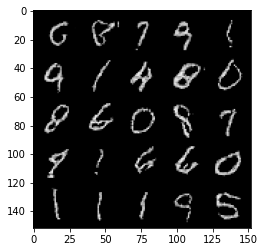

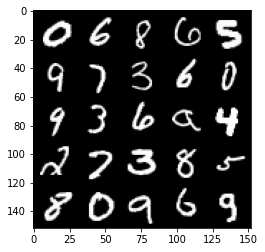

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 2: Generator loss: -0.8455639455318452, Critic loss: 0.02687367505952718


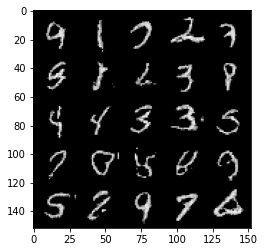

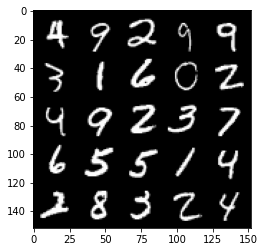

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 3: Generator loss: -0.7724454563260077, Critic loss: 0.031176738109439613


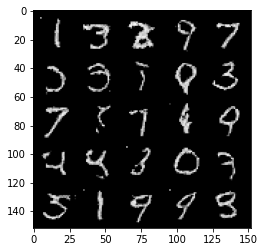

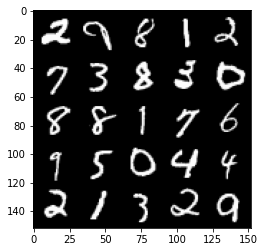

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 4: Generator loss: -0.8002132614254956, Critic loss: 0.02422722679562864


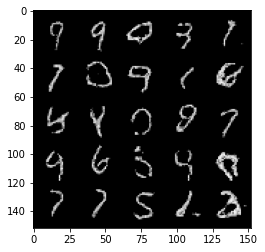

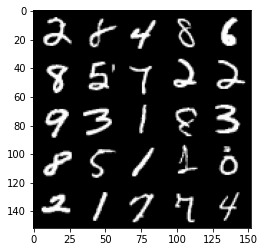

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 5: Generator loss: -0.7779786683619022, Critic loss: 0.03432315413467588


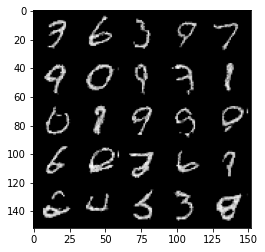

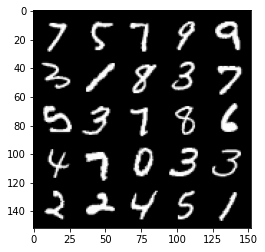

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 6: Generator loss: -0.8409410361647603, Critic loss: 0.028573551595211046


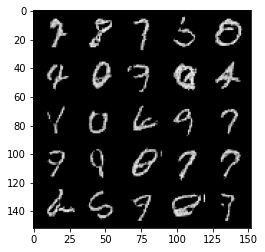

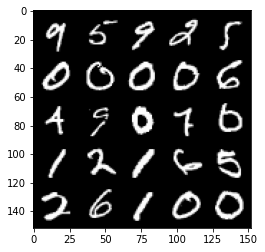

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 7: Generator loss: -0.9456548151969912, Critic loss: 0.041212670184671875


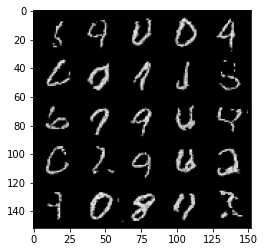

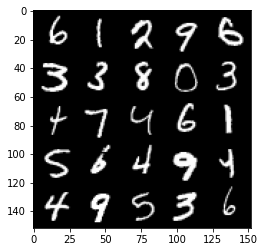

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 8: Generator loss: -0.6652397968471044, Critic loss: 0.027575614067725802


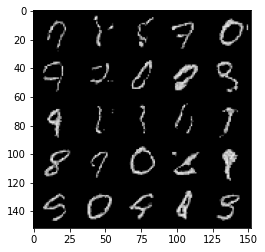

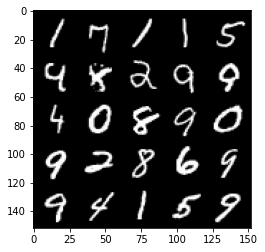

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 9: Generator loss: -0.9467834383174779, Critic loss: 0.027364739602431666


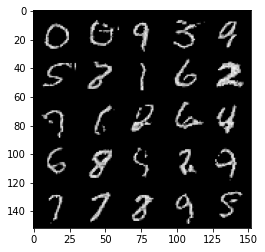

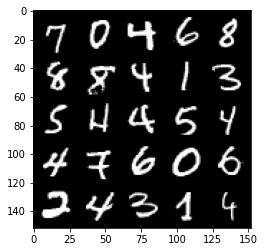

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



epoch 10: Generator loss: -0.9228487081527702, Critic loss: 0.032540817750617866


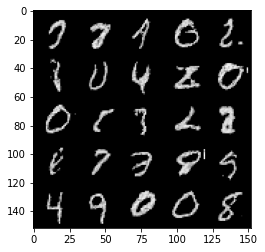

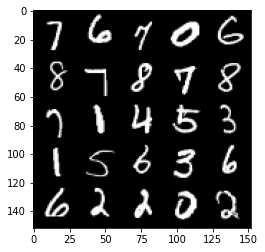

In [32]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_critic_loss = 0
c_lambda = 10
crit_repeats = 5

for epoch in range(1, n_epochs+1): # 기존에 100 epoch 수행
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # Update crit
        crit_opt.zero_grad()
        latent = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(latent)
        crit_fake_pred = crit(fake)
        crit_real_pred = crit(real)
        gradient = get_gradient(crit, real, fake, 0.5) 
        gp = gradient_penalty(gradient)
        crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
        
        # track the average crit loss
        mean_critic_loss += crit_loss.item() /display_step
        crit_loss.backward(retain_graph=True)
        crit_opt.step()
        
        # Update generator
        gen_opt.zero_grad()
        latent_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(latent_2)
        crit_fake_pred = crit(fake_2)
        gen_loss = get_gen_loss(crit_fake_pred)
        

        # track the average gen loss
        mean_generator_loss += gen_loss.item() / display_step
        gen_loss.backward()
        gen_opt.step()

        # visualize the results
    if epoch % 1 == 0:
      print(f"epoch {epoch}: Generator loss: {mean_generator_loss}, Critic loss: {mean_critic_loss}")
      fake_noise = get_noise(cur_batch_size, z_dim, device =device)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_critic_loss = 0